# 이커머스 데이터 활용 지표 _KPI & RFM
| 마케터, 서비스 기획자
문제상황: 런칭 이후 사용자들이 빠르게 상승하였지만, 현재는 정체기에 빠져있다. \
1) 현재 서비스 이용 수준이 어떻게 되고 있으며 2) 런칭 이후 어떻게 변해왔는지를 파악하기 위해 다양한 분석을 수행하고자 한다.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#'csv파일 인코딩방법' 이라고 구글링해서 알아두면 좋음
data = pd.read_csv('./chapter18_e_commerce.csv', encoding = 'ISO-8859-1')
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


**데이터**

* 이커머스 온라인 구매 데이터
* 데이터 명세 ⬇

|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country| 
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|송장번호|재고코드(물품코드)|물품상세설명|수량|송장날짜(구매일)|개당가격|고객ID|나라|




In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## 문제해결 프로세스 정의
> 문제정의\
: 런칭 이휴 서비스 정체기로 인한 영업이익, 사용 고객 수 감소\
> 기대효과\
: 정체 원인 파악 및 대응책 수립 및 실행을 통한 영업이익, 사용 고객 수 증가
\
> 해결방안\
: 구매 데이터 활용 서비스 이용 현황 파악(지표기획)\
 -> 데이터 전처리 -> RFM 모델에 대한 이해와 각 지표 설정 -> RFM활용 서비스 지표 기혹 및 개발
 
 + 인사이트 리포트: 현황 파악 + 액션까지 제시

### 데이터 전처리

In [5]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# 숫자형 데이터만 나옴
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


-> quantity와 UnitPrice 값의 최소값이 마이너스 값이여서 전처리 필요

In [7]:

# CustomerID  -> drop (누가 구매했는지 알 수 없기 때문에 버릴수밖에 없음)
# Description -> CustomerID 의 null값이 더 많기 때문에, 먼저 드랍 해보고 추가적인 작업이 필요한지 확인  
data.dropna(subset = 'CustomerID', how = 'all', inplace = True) # all은 안넣어도 상관 없음


data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
# UnitPrice 양수값만 가져오기
data = data[data['UnitPrice']>0]
data.describe()

,Quantity,UnitPrice,CustomerID
count,406789.000000,406789.000000,406789.000000
mean,12.028359,3.460811,15287.795830
std,247.927842,69.318561,1713.573064
min,-80995.000000,0.001000,12346.000000
25%,2.000000,1.250000,13954.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
# Quantity 양수값만 가져오기
data = data[data['Quantity']>0]
data.describe()

,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453
std,179.331775,22.097877,1713.141560
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [10]:
print(data.shape)  
print("준 데이터",541909 -data.shape[0]) 

(397884, 8)
준 데이터 144025


간단하게 지표 확인하기

In [11]:
#이용 고객수
a = data['CustomerID'].nunique()   # 이용고객수
b =data['Quantity'].sum()   # 총 구매건수
c = data['Country'].nunique()    # 이용나라
d = data.groupby('CustomerID')['InvoiceNo'].count().mean() #인당 평균 구매 건수

print('이용고객수',a)
print('총 구매건수',b)
print('이용나라',c)
print('인당 평균 구매 건수',d)

이용고객수 4338
총 구매건수 5167812
이용나라 37
인당 평균 구매 건수 91.72060857538035


## RFM

- 고객별(CustomerID) RFM 점수 계산 및 점수 구간에 따른 서비스 등급 부여\

> Recency(최근성)\
> Frequency(구매빈도)\
> Monetary(구매금액) \

<장점>\
만들기 편하다 
\
<단점>\
등급의 기준을 나누는데 정답이 없기 떄문에 나누기가 애매하다

### Recency(최근성)

In [12]:
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


In [13]:
# InvoiceDate의 포맷 변경
# 시, 분 데이터 분할 
data['Date'] = data['InvoiceDate'].str.split(' ').str[0]   # str[0] : split한 것 중 가져올 데이터


In [14]:
data['Date'] = pd.to_datetime(data['Date'])
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01


In [15]:
data['Date'].min(), data['Date'].max()

(Timestamp('2010-12-01 00:00:00'), Timestamp('2011-12-09 00:00:00'))

***Recency*** = 현재 날짜 - 고객 ID별 가장 마지막 구매일 

In [16]:
recency_data = data.groupby('CustomerID',as_index= False )['Date'].max()  #as_index: reset_index 랑 동일
recency_data.columns = ['CustomerID', 'LastPurchaseDate']
recency_data

,CustomerID,LastPurchaseDate
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02
...,...,...
4333,18280.0,2011-03-07
4334,18281.0,2011-06-12
4335,18282.0,2011-12-02
4336,18283.0,2011-12-06


In [17]:
recency_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        4338 non-null   float64       
 1   LastPurchaseDate  4338 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 67.9 KB


In [18]:
# 현재날짜: 기존 데이터가 현재와 너무 많은 차이가 나기 때문에 maxdate로()'2011-12-09')로 가정

recency_data['Recency'] = recency_data['LastPurchaseDate'].apply(lambda x: (data['Date'].max() - x).days)

recency_data.head(5)

,CustomerID,LastPurchaseDate,Recency
0,12346.0,2011-01-18,325
1,12347.0,2011-12-07,2
2,12348.0,2011-09-25,75
3,12349.0,2011-11-21,18
4,12350.0,2011-02-02,310


In [19]:
recency_data.drop(columns =['LastPurchaseDate'],inplace = True )

## Frequency(최빈성)

- invoiceNo(rct_no와 동일): 다양한 물품을 구매해도, 송장번호가 한개면 한번 구매한것으로 여김

In [20]:
frequency_data = data.copy()

# 어떤 물품을 구매했는지가 아니라, 한 사람한테 몇개의 송장번호가 있는지 매칭 시킬것
frequency_data.drop_duplicates(subset = ['CustomerID','InvoiceNo'], keep = 'first',inplace = True)

#
frequency_data = frequency_data.groupby('CustomerID', as_index = False)['InvoiceNo'].count()
frequency_data.columns = ['CustomerID','Frequency']
frequency_data.head(3)

,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4


## Monetary (금액)
구매금액 = 구매개수 * 구매단가

In [24]:
# Quantity : amn_ct와 동일
data['Total_cost'] =data['UnitPrice']*data['Quantity']
monetary_data = data.groupby('CustomerID',as_index = False)['Total_cost'].sum()
monetary_data.columns = ['CustomerID','Monetary']
monetary_data.head(3)


,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24


## merge 해주기

In [25]:
recency_data

,CustomerID,Recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310
...,...,...
4333,18280.0,277
4334,18281.0,180
4335,18282.0,7
4336,18283.0,3


In [26]:
frequency_data

,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1
...,...,...
4333,18280.0,1
4334,18281.0,1
4335,18282.0,2
4336,18283.0,16


In [27]:
rf = recency_data.merge(frequency_data, how = 'left', on='CustomerID')

rfm = rf.merge(monetary_data, how = 'left', on='CustomerID')


rfm.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24


- RFM을 하나의 점수로 환산시켜야 함
- 현재 각각의 단위가 다르기 때문에 각 컬럼별 기준으로 표준화 필요

## 스케일링
- minmax_scale: 최대값을 1. 최소값을 0으로 표준화 하는 기법

In [28]:
from sklearn.preprocessing import minmax_scale

## 최근성: 숫자가 작을수록 좋음
# 즉, 최근 구매일이 얼마 지나지 않은 고객이 더 점수가 높음

rfm['Recency'] = minmax_scale(rfm['Recency'], axis = 0, copy = True )
#행기준으로, 카피해서 만들기
rfm['Recency'] = 1 - rfm['Recency']  # 작은값이 좋기 때문에, 1에서 빼줌(반전)


rfm['Frequency'] = minmax_scale(rfm['Frequency'], axis = 0, copy = True )
rfm['Monetary'] = minmax_scale(rfm['Monetary'], axis = 0, copy = True )




# score
rfm['Score'] = rfm['Recency'] + rfm['Frequency'] + rfm['Monetary']




rfm.head(5)

,CustomerID,Recency,Frequency,Monetary,Score
0,12346.0,0.128686,0.000000,0.275443,0.404130
1,12347.0,0.994638,0.028846,0.015368,1.038853
2,12348.0,0.798928,0.014423,0.006401,0.819751
3,12349.0,0.951743,0.000000,0.006259,0.958002
4,12350.0,0.168901,0.000000,0.001180,0.170081


In [42]:
rfm[(rfm['Recency'] == 1 )& (rfm['Frequency'] == 1)]

,CustomerID,Recency,Frequency,Monetary,Score
326,12748.0,1.0,1.0,0.120327,86.0


In [44]:
rfm[rfm['Score'] == 100]

,CustomerID,Recency,Frequency,Monetary,Score
1879,14911.0,0.997319,0.961538,0.513277,100.0


In [45]:
0.997319 + 0.961538 + 0.513277

2.472134

In [30]:
# score 에 minmax_scale 적용
# 100을 곱해서 100점 만점으로 스케일링

rfm['Score'] = minmax_scale(rfm['Score'], axis = 0, copy = True) * 100

rfm['Score'] = round(rfm['Score'], 0)


In [31]:
rfm.head(3)

,CustomerID,Recency,Frequency,Monetary,Score
0,12346.0,0.128686,0.000000,0.275443,16.0
1,12347.0,0.994638,0.028846,0.015368,42.0
2,12348.0,0.798928,0.014423,0.006401,33.0


## 점수 구간화

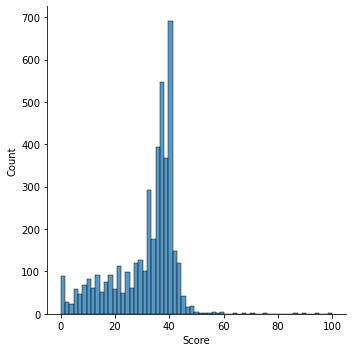

In [37]:
sns.displot(rfm['Score']);

기준을 정하는 것은 어려움

> 현재 그래프\
    - 60점 이상 고객은 매우 없음 > 우량고객\
    - 40 ~ 60점 > strong \
    - 20 ~ 40 > nomal \
    - 10 ~ 20 > week \ 
    - 0 ~ 10 > very week

In [49]:
#점수별 고객 등급 부여
rfm['Grade'] = rfm['Score'].apply(lambda x: '01. Very Strong' if x>=60 
                                  else('02.Strong' if x>=40 
                                    else( '03.Normal' if x>=20 
                                      else('04.Week' if x>=10 else '05. Very week'))))

In [50]:
rfm.head(3)

,CustomerID,Recency,Frequency,Monetary,Score,Grade
0,12346.0,0.128686,0.000000,0.275443,16.0,04.Week
1,12347.0,0.994638,0.028846,0.015368,42.0,02.Strong
2,12348.0,0.798928,0.014423,0.006401,33.0,03.Normal


In [51]:
# 기존 원본 데이터에 고객 등급 left join으로 merge

data = pd.merge(data,rfm, how = 'left', on = 'CustomerID')
data.head(3)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Total_cost,Recency,Frequency,Monetary,Score,Grade
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01,15.30,0.002681,0.158654,0.019227,7.0,05. Very week
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01,20.34,0.002681,0.158654,0.019227,7.0,05. Very week
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01,22.00,0.002681,0.158654,0.019227,7.0,05. Very week


#### 월별 분석을 위한 준비과정
지표 기획에 앞서, 년월만 새로운 col로 정의\
*** dt.strftime('%Y-%m')***

In [52]:
data['Date_1'] = data['Date'].dt.strftime('%Y-%m') # 년월만
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Total_cost,Recency,Frequency,Monetary,Score,Grade,Date_1
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01,15.30,0.002681,0.158654,0.019227,7.0,05. Very week,2010-12
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01,20.34,0.002681,0.158654,0.019227,7.0,05. Very week,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01,22.00,0.002681,0.158654,0.019227,7.0,05. Very week,2010-12


## 지표기획

##### 1. 월별 이용 고객 현황

In [54]:
data_cus = data.groupby('Date_1', as_index=False)['CustomerID'].nunique()
data_cus.head(3)

,Date_1,CustomerID
0,2010-12,885
1,2011-01,741
2,2011-02,758


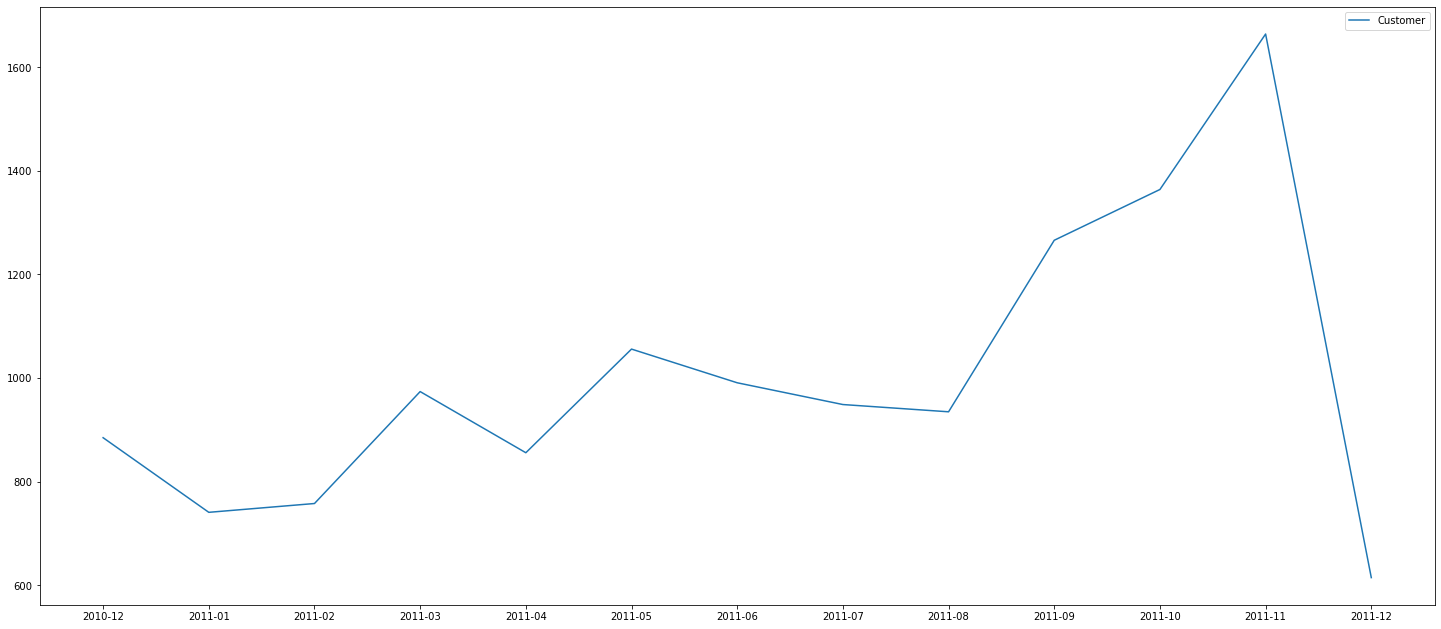

In [63]:
plt.plot(data_cus['Date_1'], data_cus['CustomerID'], label = 'Customer');
plt.legend();

plt.gcf().set_size_inches(25,11)

12월에 고객수 급감함

#### 월별 이용 건수

In [64]:
data_cnt = data.groupby('Date_1', as_index=False)['CustomerID'].count()
data_cnt.head(3)

,Date_1,CustomerID
0,2010-12,26157
1,2011-01,21229
2,2011-02,19927


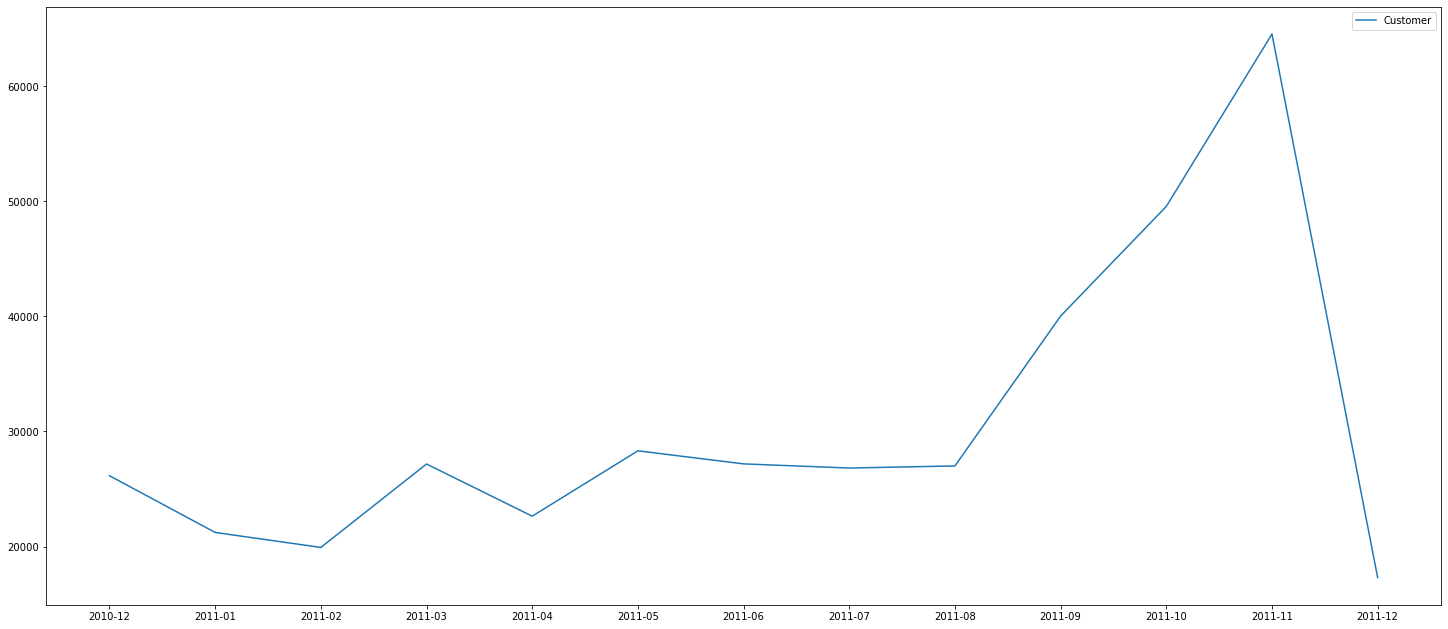

In [71]:
plt.plot(data_cnt['Date_1'], data_cnt['CustomerID'], label = 'Customer');
plt.legend();

plt.gcf().set_size_inches(25,11)

#### 송장건수

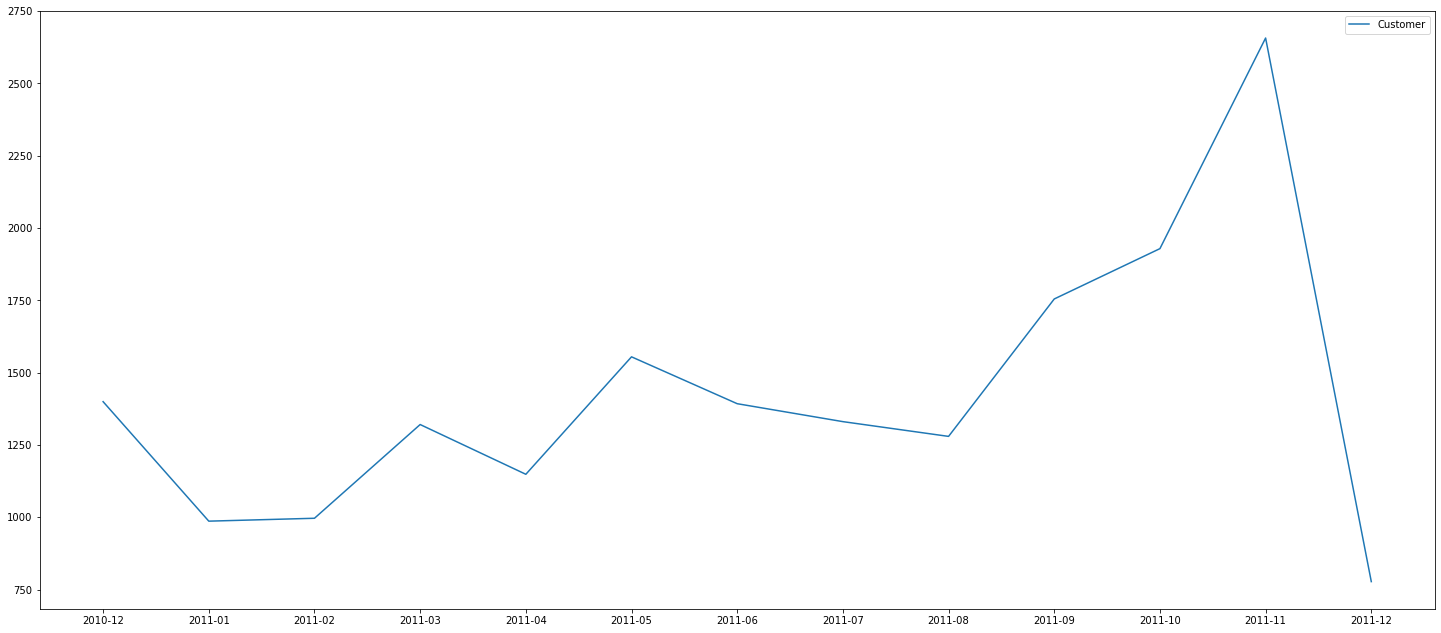

In [73]:
data_invoice = data.groupby('Date_1', as_index=False)['InvoiceNo'].nunique()
plt.plot(data_invoice['Date_1'], data_invoice['InvoiceNo'], label = 'Customer');
plt.legend();

plt.gcf().set_size_inches(25,11)

#### 월별 이용 국가

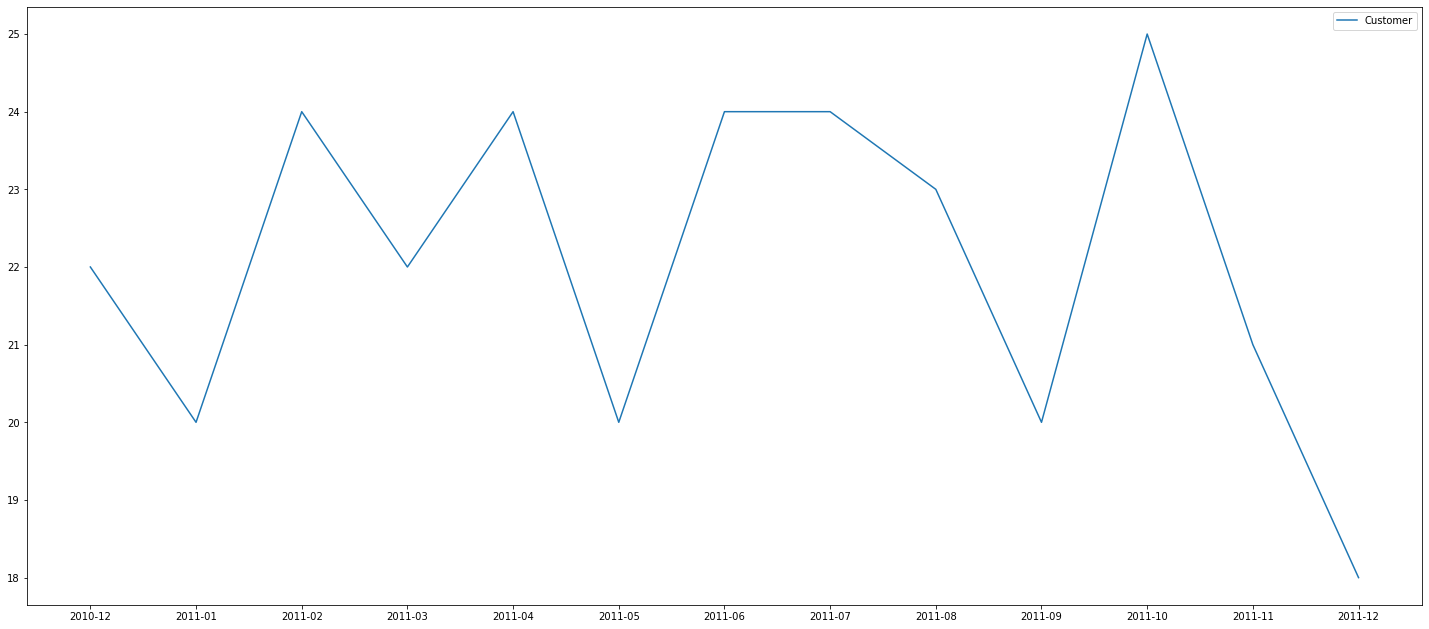

In [75]:
data_country = data.groupby('Date_1', as_index=False)['Country'].nunique()
plt.plot(data_country['Date_1'], data_country['Country'], label = 'Customer');
plt.legend();

plt.gcf().set_size_inches(25,11)

#### 최빈 이용 국가 (충성도 이용 고객 나라)

In [117]:
a = pd.DataFrame(data.groupby(['Date_1','Country'])['InvoiceNo'].nunique()).head(60)
a

InvoiceNo
Date_1  Country                   
2010-12 Australia                3
        Austria                  1
        Belgium                  5
        Channel Islands          1
        Cyprus                   1
        Denmark                  1
        EIRE                    15
        Finland                  1
        France                  21
        Germany                 30
        Iceland                  1
        Italy                    2
        Japan                    3
        Lithuania                4
        Netherlands              3
        Norway                   2
        Poland                   1
        Portugal                 6
        Spain                    4
        Sweden                   2
        Switzerland              2
        United Kingdom        1291
2011-01 Australia                9
        Belgium                  3
        Channel Islands          1
        Cyprus                   1
        EIRE                     7
        Finland                  2
        France                  29
        Germany                 31
        Greece                   1
        Iceland                  1
        Italy                    3
        Lebanon                  1
        Netherlands              5
        Poland                   1
        Portugal                 4
        Singapore                1
        Spain                    8
        Sweden                   2
        Switzerland              3
        United Kingdom         874
2011-02 Australia                5
        Austria                  2
        Belgium                  8
        Channel Islands          1
        Cyprus                   6
        Czech Republic           1
        Denmark                  1
        EIRE                     9
        Finland                  1
        France                  21
        Germany                 19
        Israel                   1
        Italy                    1
        Japan                    2
        Netherlands              5
        Norway                   2
        Poland                   2
        Portugal                 2

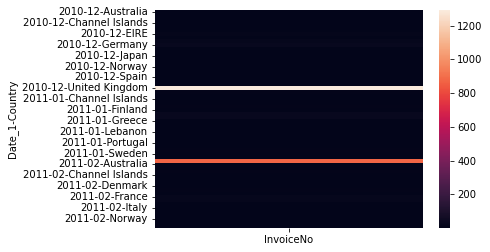

In [118]:
sns.heatmap(a);

#### 월별 Grade 이용 비중

In [121]:
data_grade = data.groupby(['Date_1', 'Grade'], as_index = False)['CustomerID'].nunique()
data_grade.head(3)

,Date_1,Grade,CustomerID
0,2010-12,01. Very Strong,11
1,2010-12,02.Strong,397
2,2010-12,03.Normal,291


In [125]:
data_pivot = pd.pivot_table(data_grade,
                           index = 'Date_1',
                            columns = 'Grade',
                            values = 'CustomerID' )
data_pivot.fillna(0, inplace = True)
data_pivot['total'] = data_pivot['01. Very Strong']+ data_pivot['02.Strong'] + data_pivot['03.Normal' ] + data_pivot['04.Week' ]+ data_pivot['05. Very week' ]

data_pivot
# 각각 total 값으로 나눠주기




Grade,01. Very Strong,02.Strong,03.Normal,04.Week,05. Very week,total
Date_1,,,,,,
2010-12,11.0,397.0,291.0,42.0,144.0,885.0
2011-01,11.0,334.0,259.0,34.0,103.0,741.0
2011-02,11.0,318.0,286.0,43.0,100.0,758.0
2011-03,12.0,391.0,378.0,193.0,0.0,974.0
2011-04,12.0,360.0,338.0,146.0,0.0,856.0
2011-05,13.0,449.0,453.0,141.0,0.0,1056.0
2011-06,12.0,424.0,555.0,0.0,0.0,991.0
2011-07,12.0,421.0,516.0,0.0,0.0,949.0
2011-08,12.0,424.0,499.0,0.0,0.0,935.0
